<p align="center">
    <img width=210 height=150 src="../reports/figures/cunef_bw.png">
</p>

<div>
<h1>3.0 Models </h1>
Fake News Classifier <br>
<strong>Ciencia de Datos para la Información No Estructurada</strong> <br>
<strong>Master Universidatio en Ciencia de Datos</strong>
</div>

<div style='text-align:right'>Carlos Viñals Guitart (<i>carlos.vinals@cunef.edu</i>)</div>

---

A continuación vamos a crear los distintos modelos para evaluar la detección de noticias falsas

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
import scikitplot as skplt

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline



Ahora procederemos a crear las funciones que agilizaran la ejecución y evaluación de los modelos.
Las siguientes funciones nos permitiran graficar las matrices de confusión y curvas del modelo. No lo haremos para todos pero si para aquellos que consideremos relevantes.

In [2]:
# Ploting functions for the models
def confusion_matrix(titles_options = None, test = None, pred = None, labels = None):
    '''
    Prints confusion matrix making the predictions
    :param titles_options:
    :param test:
    :param pred:
    :param labels:
    :return:
    '''
    for title, normalize in titles_options:
        disp = metrics.ConfusionMatrixDisplay.from_predictions(
            test,
            pred,
            display_labels=labels,
            cmap=plt.cm.Blues,
            normalize=normalize
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

def model_curves_summary(test = None, pred = None, label = 'Model'):
    '''
    Prints a plot report with four different plots: ROC curve, PR curve,
    Gain curve, Lift curve
    :param test: Real values
    :param pred: Predicted values
    :param label: Model name
    '''
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=False)
    fig.suptitle('Curvas del modelo ' + label)

    # ROC CURVE
    fpr, tpr, thresholds = metrics.roc_curve(test, pred[:,1])
    # plot the roc curve for the model
    axes[0,0].plot([0,1], [0,1], linestyle='--', label='No Skill')
    axes[0,0].plot(fpr, tpr, marker='.', label=label)
    # axis labels
    axes[0,0].set_title('Curva ROC')
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].legend()
    axes[0,0].grid()

    # Precission-Recall CURVE
    # calculate pr-curve
    precision, recall, thresholds = metrics.precision_recall_curve(test, pred[:,1])
    no_skill = len(test[test==1]) / len(test)
    axes[0,1].plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    axes[0,1].plot(recall, precision, marker='.', label=label)
    # axis labels
    axes[0,1].set_title('Curva Precission-Recall')
    axes[0,1].set(xlabel='Precission', ylabel='Recall')
    axes[0,1].legend()
    axes[0,1].grid()

    # GAIN CURVE
    skplt.metrics.plot_cumulative_gain(test, pred, ax = axes[1,0])

    # LIFT CURVE
    skplt.metrics.plot_lift_curve(test, pred, ax = axes[1,1])

Ahora crearemos una función de evaluación de los modelos para generar una tabla resumen de su funcionamiento. 

In [11]:
# Metrics list
models_report_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precission', 'Recall', 'F-score', 'AUC'])

# Model final list for later use
models_collection = {}

def model_train_test(model, traind, traind_labels, testd, testd_labels, data_info, i):
    model_name = str(type(model).__name__) + data_info

    # Training model
    print("Training model... " + model_name)
    model.fit(traind, traind_labels)

    # Prediction with model
    print("Predicting with model... " + model_name)
    y_pred = model.predict(testd)
    
    # Model information
    models_report_df.loc[i] = [
        model_name,
        metrics.accuracy_score(testd_labels, y_pred),
        metrics.precision_score(testd_labels, y_pred),
        metrics.recall_score(testd_labels, y_pred),
        metrics.f1_score(testd_labels, y_pred),
        metrics.roc_auc_score(testd_labels, y_pred)
    ]

    # Saving the model
    models_collection[model_name] = model
    
    print("Ended evaluation of model... " + model_name)

Ahora recuperaremos los datos para evaluar a los modelos. Realizaremos evaluaciones tanto con el preprocesado de Bag of Word como la versión que incluye el preprocesado Tfid de normalización de las frecuencias. 

In [4]:
# Data preprocessed with BOW only
train_bow = pd.read_csv("../data/processed/train_bow.csv")
test_bow = pd.read_csv("../data/processed/test_bow.csv")

Y_train_bow = train_bow['label']
X_train_bow = train_bow.drop(['label'], axis=1)

Y_test_bow = test_bow['label']
X_test_bow = test_bow.drop(['label'], axis=1)

# Data preprocessed with BOW and TFD 
train_tfd = pd.read_csv("../data/processed/train_tfd.csv")
test_tfd = pd.read_csv("../data/processed/test_tfd.csv")

Y_train_tfd = train_tfd['label']
X_train_tfd = train_tfd.drop(['label'], axis=1)

Y_test_tfd = test_tfd['label']
X_test_tfd = test_tfd.drop(['label'], axis=1)

Probaremos los siguientes modelos: Árbol de Decisión, Regresor Lineal, RandomForest y Naive Bayes Binomial. 
Primero comenzaremos con los modelos para los datos con preprocesado BOW...

In [13]:
models = [tree.DecisionTreeClassifier(), RandomForestClassifier(), MultinomialNB(), GradientBoostingClassifier()]

for i, m in enumerate(models):
    model_train_test(m, X_train_bow, Y_train_bow, X_test_bow, Y_test_bow, "", i)

Training model... DecisionTreeClassifier
Predicting with model... DecisionTreeClassifier
Ended evaluation of model... DecisionTreeClassifier
Training model... RandomForestClassifier
Predicting with model... RandomForestClassifier
Ended evaluation of model... RandomForestClassifier
Training model... MultinomialNB
Predicting with model... MultinomialNB
Ended evaluation of model... MultinomialNB
Training model... GradientBoostingClassifier
Predicting with model... GradientBoostingClassifier
Ended evaluation of model... GradientBoostingClassifier


In [14]:
models_report_df

,Model,Accuracy,Precission,Recall,F-score,AUC
0,DecisionTreeClassifier,0.767613,0.769556,0.764706,0.767123,0.767616
1,RandomForestClassifier,0.830705,0.863741,0.785714,0.822882,0.830752
2,MultinomialNB,0.819138,0.816667,0.823529,0.820084,0.819133
3,GradientBoostingClassifier,0.744479,0.817439,0.630252,0.711744,0.744600


Matriz de confusión
[[416  59]
 [102 374]]
Matriz de confusión normalizada
[[0.87578947 0.12421053]
 [0.21428571 0.78571429]]


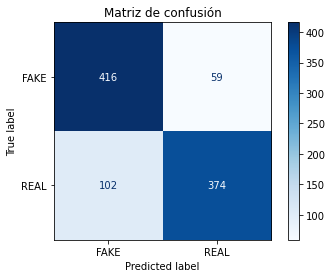

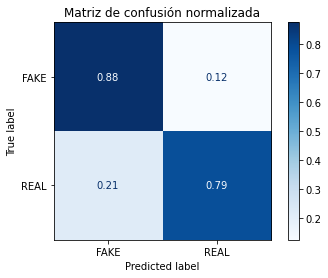

In [16]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test_bow, models_collection['RandomForestClassifier'].predict(X_test_bow), 
                            ['FAKE', 'REAL'])

Matriz de confusión
[[387  88]
 [ 84 392]]
Matriz de confusión normalizada
[[0.81473684 0.18526316]
 [0.17647059 0.82352941]]


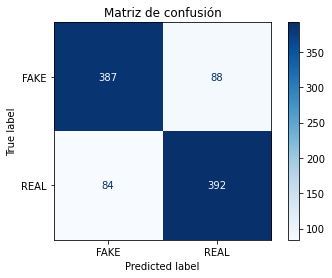

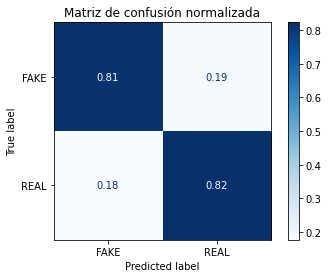

In [18]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test_bow, models_collection['MultinomialNB'].predict(X_test_bow), 
                            ['FAKE', 'REAL'])

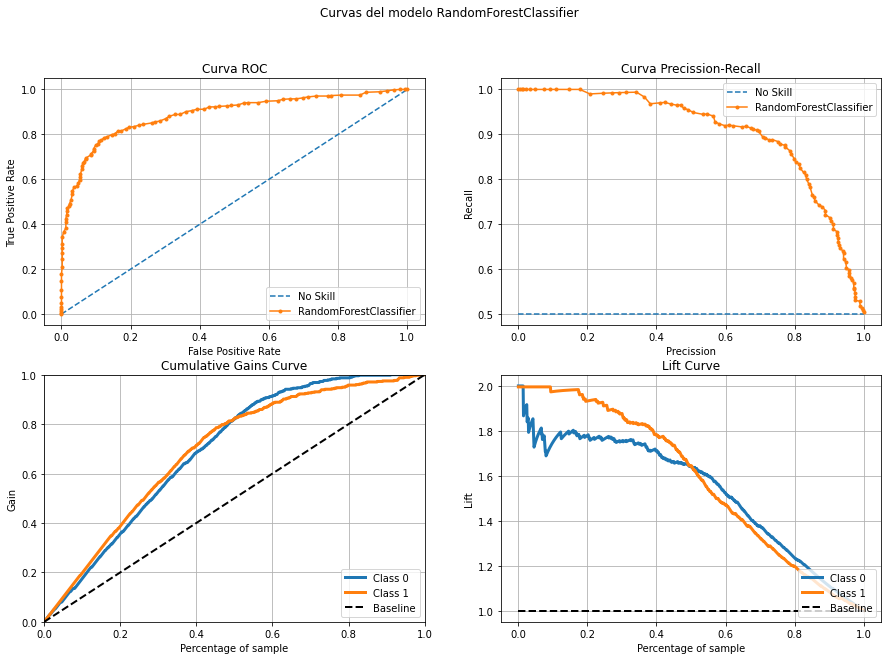

In [20]:
model_curves_summary(Y_test_bow, models_collection['RandomForestClassifier'].predict_proba(X_test_bow), "RandomForestClassifier")

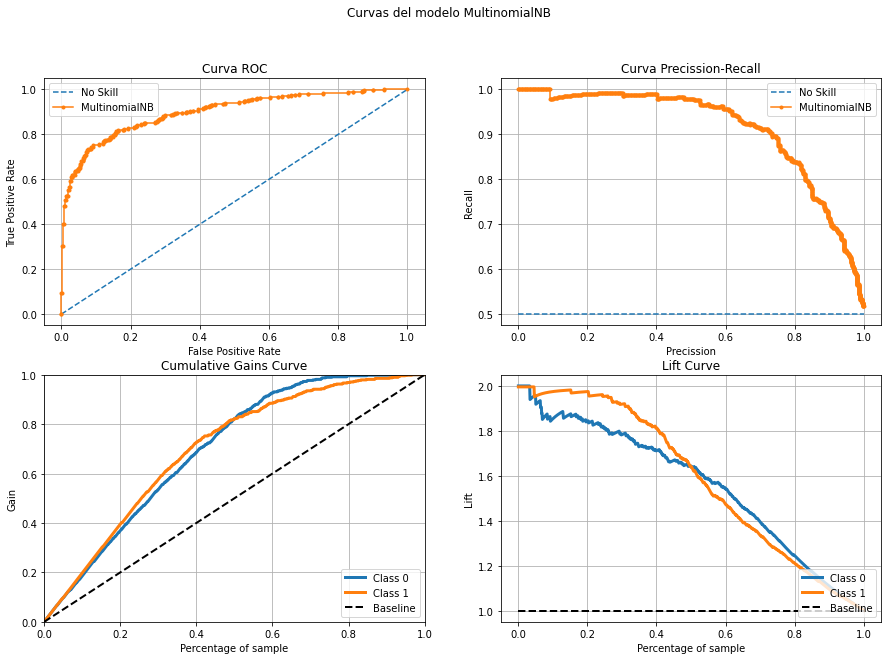

In [21]:
model_curves_summary(Y_test_bow, models_collection['MultinomialNB'].predict_proba(X_test_bow), "MultinomialNB")

In [63]:

def cleaning_data(tlt_df):
    # Translator to clean data 
    translator = str.maketrans('', '', string.punctuation)

    # Word lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()

    # Stopwords
    stopwords = nltk.corpus.stopwords.words('english')

    return tlt_df.map(lambda x : " ".join(
        [wordnet_lemmatizer.lemmatize(word, pos="v") for word in 
        re.sub(r"[^a-zA-Z0-9]", " ", x.strip().lower().translate(translator)).split() if not word in stopwords])
)
#steps = [("Count", CountVectorizer()), ("Transform", TfidfTransformer()), ('Model', MultinomialNB())]
estimator_model =  make_pipeline(CountVectorizer(), TfidfTransformer(), MultinomialNB())

In [64]:
train_full = pd.read_csv("../data/interim/train.csv")
Y_train = train_full['label'].str.replace("FAKE", "0").str.replace("REAL", "1").map(lambda x : int(x))
X_train = cleaning_data(train_full.drop(['label'], axis=1)['title'])

In [60]:
estimator_model.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('tfidftransformer', TfidfTransformer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'tfidftransformer': TfidfTransformer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'tfidftransformer__norm': 'l2',
 'tfidftransform

In [105]:
param_grid = {
    'countvectorizer__binary': [True, False],
    'tfidftransformer__norm': [None, 'l1', 'l2'],
    "multinomialnb__alpha": [0.01, 0.05, 0.1, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 1, 1.5, 2],
    "multinomialnb__fit_prior": [True, False]
}

search = GridSearchCV(estimator_model, param_grid, scoring="f1")

In [106]:
result = search.fit(X_train, Y_train)

In [108]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.8131238392784017
Best Hyperparameters: {'countvectorizer__binary': False, 'multinomialnb__alpha': 0.4, 'multinomialnb__fit_prior': False, 'tfidftransformer__norm': 'l1'}


In [110]:
final_model = Pipeline(
    [('vector', CountVectorizer(binary=False)),
    ('transform', TfidfTransformer(norm='l1')),
    ('model', MultinomialNB(alpha=0.4, fit_prior=False))]
)

final_model.fit(X_train, Y_train)

Pipeline(steps=[('vector', CountVectorizer()),
                ('transform', TfidfTransformer(norm='l1')),
                ('model', MultinomialNB(alpha=0.4, fit_prior=False))])

In [111]:
test_full = pd.read_csv("../data/interim/test.csv")
Y_test = test_full['label'].str.replace("FAKE", "0").str.replace("REAL", "1").map(lambda x : int(x))
X_test = cleaning_data(test_full.drop(['label'], axis=1)['title'])

In [112]:
Y_pred = final_model.predict(X_test)

In [113]:
metrics.accuracy_score(Y_test, Y_pred)

0.8012618296529969

Matriz de confusión
[[351 124]
 [ 65 411]]
Matriz de confusión normalizada
[[0.73894737 0.26105263]
 [0.13655462 0.86344538]]


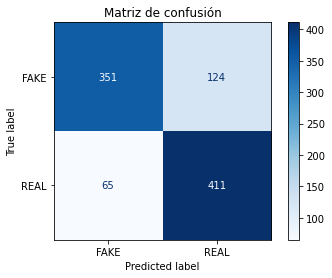

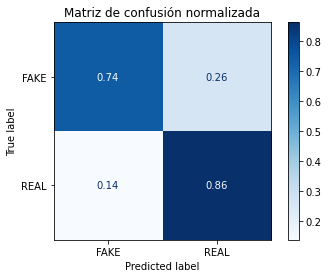

In [114]:
titles_options = [
    ("Matriz de confusión", None),
    ("Matriz de confusión normalizada", "true"),
]
confusion_matrix(titles_options, Y_test, Y_pred, 
                            ['FAKE', 'REAL'])

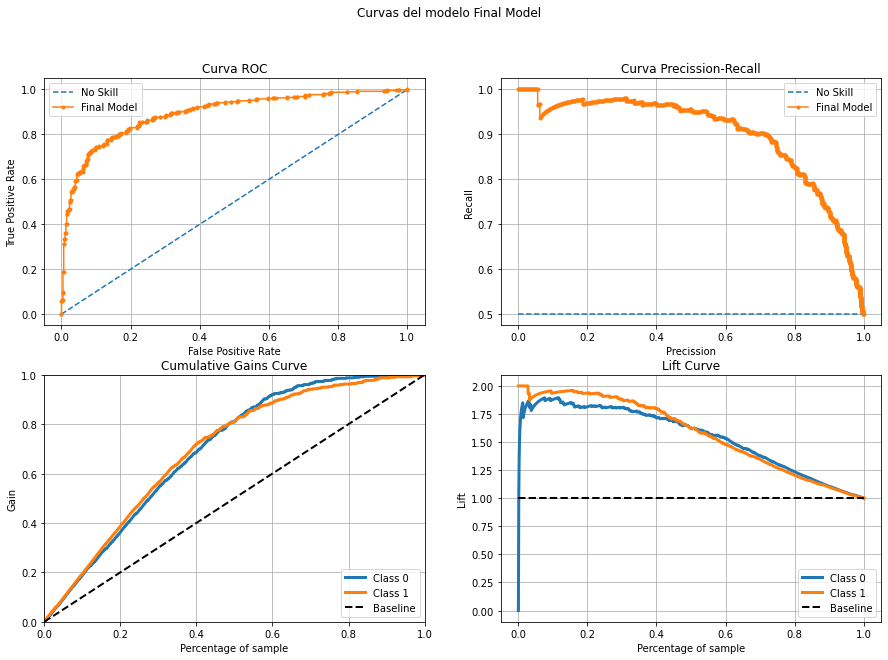

In [115]:
model_curves_summary(Y_test, final_model.predict_proba(X_test), "Final Model")